In [10]:
# system
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))

from config.path import get_training_data_path, get_all_files_from_folder

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def find_contours_and_extreme_points(image):
    #image = cv2.imread(image_path)
    original_image = image.copy()  # Keep a copy of the original image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (1, 1), 0)
    _, thresh = cv2.threshold(blurred, 70, 105, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Assume largest contour is our object of interest
    if contours:
        c = max(contours, key=cv2.contourArea)
        # Compute the bounding box of the contour
        x, y, w, h = cv2.boundingRect(c)

        # Draw the contour and bounding box
        cv2.drawContours(image, [c], -1, (0, 255, 0), 2)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Calculate extreme points
        leftmost = tuple(c[c[:, :, 0].argmin()][0])
        rightmost = tuple(c[c[:, :, 0].argmax()][0])
        topmost = tuple(c[c[:, :, 1].argmin()][0])
        bottommost = tuple(c[c[:, :, 1].argmax()][0])

        # Draw extreme points
        cv2.circle(image, leftmost, 8, (0, 0, 255), -1) # Red
        cv2.circle(image, rightmost, 8, (0, 128, 255), -1) # Orange
        cv2.circle(image, topmost, 8, (255, 0, 0), -1) # Blue
        cv2.circle(image, bottommost, 8, (255, 255, 0), -1) # Yellow

        # Draw lines between extreme points
        cv2.line(image, leftmost, rightmost, (255, 255, 255), 2)
        cv2.line(image, topmost, bottommost, (255, 255, 255), 2)

        # Calculate moments to find the center of mass
        M = cv2.moments(c)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX, cY = 0, 0

        # Draw the center of mass
        cv2.circle(image, (cX, cY), 8, (255, 255, 255), -1) # White

        # Calculate the angles of the lines
        angle_horizontal = np.arctan2(rightmost[1] - leftmost[1], rightmost[0] - leftmost[0])
        angle_vertical = np.arctan2(bottommost[1] - topmost[1], bottommost[0] - topmost[0])
        
        # Average the angles
        average_angle = np.degrees((angle_horizontal + angle_vertical) / 2)

        # Rotate the image to make the average angle zero
        (h, w) = original_image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, -average_angle, 1.0)
        rotated_image = cv2.warpAffine(original_image, M, (w, h))

        return average_angle

In [29]:
def rotate_image(image_path, angle):
    # Load the image
    image = cv2.imread(image_path)
    
    if image is None:
        raise ValueError("Image not found or path is incorrect.")
    
    # Get the dimensions of the image
    (height, width) = image.shape[:2]
    
    # Compute the center of the image
    center = (width // 2, height // 2)
    
    # Get the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # Compute the new dimensions of the image
    # This ensures the rotated image fits in the frame
    abs_cos = abs(rotation_matrix[0, 0])
    abs_sin = abs(rotation_matrix[0, 1])
    
    # Compute new bounding dimensions
    new_width = int(height * abs_sin + width * abs_cos)
    new_height = int(height * abs_cos + width * abs_sin)
    
    # Adjust the rotation matrix to take into account the translation
    rotation_matrix[0, 2] += (new_width / 2) - center[0]
    rotation_matrix[1, 2] += (new_height / 2) - center[1]
    
    # Rotate the image
    rotated_image = cv2.warpAffine(image, rotation_matrix, (new_width, new_height))
    
    return rotated_image


In [68]:
path = get_training_data_path(data_type='classifier', class_type='pant')
files = get_all_files_from_folder(path)
files = files[:30]
len(files)

30

Mean Absolute Error: 95.89°
Standard Deviation of Error: 44.32°


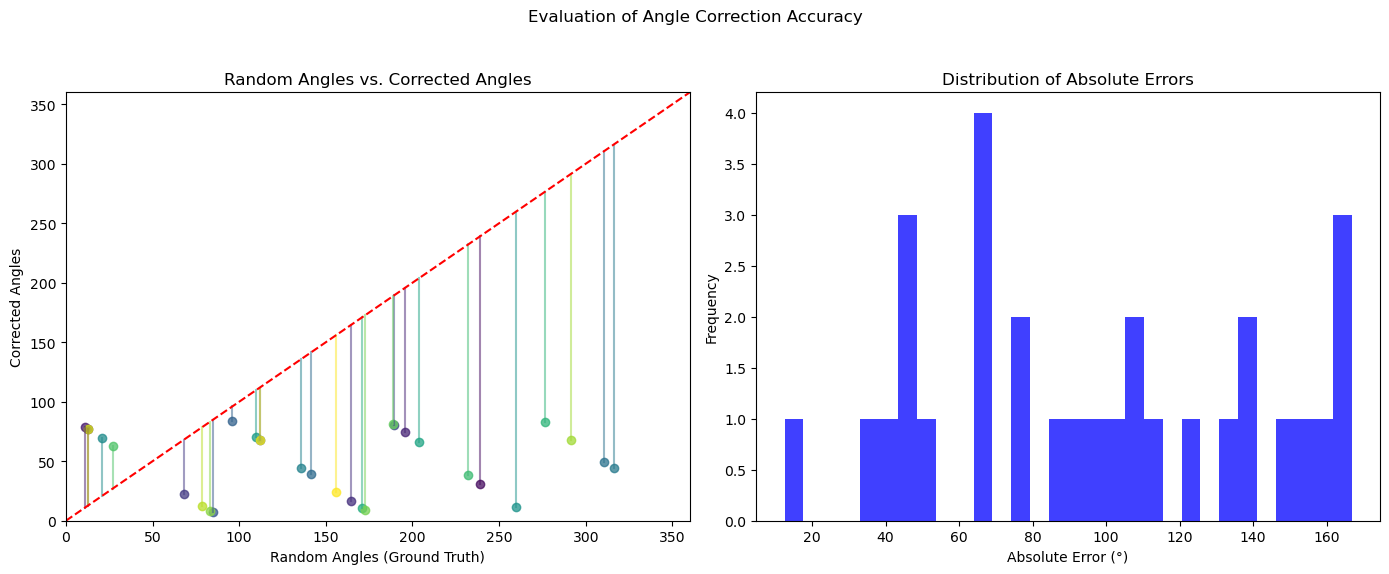

In [69]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np

# Assuming rotate_image and find_contours_and_extreme_points are already defined

res = []

for file in files:
    fullpath = os.path.join(path, file)
    random_angle = random.uniform(0, 360)
    img = rotate_image(fullpath, random_angle)
    corrected_angle = find_contours_and_extreme_points(img)
    res.append([random_angle, corrected_angle])

# Convert to numpy array for easier manipulation
res = np.array(res)
random_angles = res[:, 0]
corrected_angles = res[:, 1]

# Compute absolute errors
errors = np.abs(random_angles - corrected_angles)
errors = np.minimum(errors, 360 - errors)  # Account for circular nature of angles

# Calculate summary statistics
mean_error = np.mean(errors)
std_error = np.std(errors)

# Print summary statistics
print(f'Mean Absolute Error: {mean_error:.2f}°')
print(f'Standard Deviation of Error: {std_error:.2f}°')

# Assign unique colors to each pair
colors = plt.cm.viridis(np.linspace(0, 1, len(random_angles)))

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot of random angles vs. corrected angles with pair-wise colors and lines
for i in range(len(random_angles)):
    ax[0].scatter(random_angles[i], corrected_angles[i], color=colors[i], alpha=0.75)
    ax[0].plot([random_angles[i], random_angles[i]], [random_angles[i], corrected_angles[i]], color=colors[i], alpha=0.5, linestyle='-')

ax[0].plot([0, 360], [0, 360], color='red', linestyle='--')  # Perfect correlation line
ax[0].set_xlabel('Random Angles (Ground Truth)')
ax[0].set_ylabel('Corrected Angles')
ax[0].set_title('Random Angles vs. Corrected Angles')
ax[0].set_xlim([0, 360])
ax[0].set_ylim([0, 360])

# Histogram of errors
ax[1].hist(errors, bins=30, alpha=0.75, color='blue')
ax[1].set_xlabel('Absolute Error (°)')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Distribution of Absolute Errors')

plt.suptitle('Evaluation of Angle Correction Accuracy')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [65]:
print(random_angles)
print(corrected_angles)

[158.0123969   14.19855365 105.82712115 202.51207179 276.53853244
 296.78807376 227.6186562  292.4196227  126.08046459 294.95722085
   9.27600815 231.79574388 159.6219293  278.58599562 216.02326501
 149.49640217 108.74664646 122.68094216 198.36619254 248.72226418
 231.62083764  46.38727161 262.36384093 187.66900532 267.88517039
  56.78445536 245.16728546 208.00629829 259.96516955 272.01257141]
[22.27591849 75.7458405  74.18584768 67.48841128 83.30648534 63.20183104
 42.58167324 67.56350571 54.01094363 65.0285223  80.65642878 38.34767689
 20.732924   81.31940768 54.09192286 30.66544729 71.25374584 57.37783716
 71.60166179 21.49994483 38.51051462 43.64871262  8.50614411 82.45127739
  5.08876095 33.36872609 25.11169377 62.08769517 10.77240093 87.38898855]
